# Simulation of various experimental conditions with the MARM1 model

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pysb.simulator import ScipyOdeSimulator
from pysb.core import as_complex_pattern

from MARM1 import model

## User-defined experimental setup
Choose the experiment to simulate by altering the following variables and re-running the notebook:

1. **EGFR** under- or over-expression. 1.0 represents the typical copy number, < 1 denotes underexpression, and > 1 denotes overexpression.

In [3]:
EGFR_expression = 1.0

2. **RAF inhibitor** pre-treatment concentration in μM.

In [4]:
RAFi_concentration = 1.0

3. **MEK inhibitor** pre-treatment concentration in μM.

In [5]:
MEKi_concentration = 0.0

4. **EGF** treatment concentration in ng/mL.

In [6]:
EGF_concentration = 100

5. (Optional) Which of the 100 best-fit parameter sets to use for the simulation. Set 0 is the best fit.

In [7]:
param_set_index = 0

## Parameter set preparation

Read in the CSV file containing the best-fit parameter sets, and drop the chi$^2$ value which we don't need here.

In [8]:
param_sets = pd.read_csv('parameter_sets.csv', index_col=0)
param_sets = param_sets.drop('chi2', axis=1)

Extract the chosen parameter set and convert it into a dict.

In [9]:
params = param_sets.iloc[param_set_index].to_dict()

Override the `EGFR_crispr` parameter with the user-specified value for EGFR under/over-expression.

In [10]:
params['EGFR_crispr'] = EGFR_expression

## Simulations

First we define some utility functions that will be used below.

In [11]:
def equilibrate(simulator, initials):
    """Simulate a model from given initial conditions until it reaches steady state"""
    scale = 10
    t_start = 1e-4
    df = None
    tspan = np.geomspace(t_start, t_start * scale)
    while True:
        print(f"    at t={tspan[-1]:<5.3g} ... ", end='', flush=True)
        res = simulator.run(tspan=tspan, initials=initials)
        df = pd.concat([df, res.dataframe.iloc[1:]])
        initials = res.species[-1]
        close = np.isclose(
            *res.species[[-1,-2]].view(float).reshape(2,-1),
            rtol=1e-3
        )
        cs = np.sum(close)
        n = len(model.species)
        print(f"{cs}/{n} species converged")
        if np.all(close):
            break
        tspan *= scale
    return df

In [12]:
def get_species_index(model, pattern):
    """Return the integer species number for a given species in the model"""
    pattern = as_complex_pattern(pattern)
    matches = [
        i for i, s in enumerate(model.species)
        if s.is_equivalent_to(pattern)
    ]
    n = len(matches)
    assert n == 1, f"Expected exactly one match, got {n}"
    return matches[0]

## Initial equilibrium
First we run the model from its baseline initial conditions until equilibrium is reached. For example protein synthesis/degradation, phosphorylation/dephosphorylation, and drug binding/unbinding all need to reach steady state to match the state of the cells in the experimental setup. There may be some time without visible progress as behind the scenes PySB runs BioNetGen to generate the reaction network and Cython to compile the resulting differential equations into efficient executable code.

In [13]:
sim = ScipyOdeSimulator(model, param_values=params)
df_eq = equilibrate(sim, None)

Compiling /home/jovyan/.cache/cython/inline/_cython_inline_bca377cf0e656f6b1afd434c991ead55.pyx because it changed.
[1/1] Cythonizing /home/jovyan/.cache/cython/inline/_cython_inline_bca377cf0e656f6b1afd434c991ead55.pyx
Compiling /home/jovyan/.cache/cython/inline/_cython_inline_348250c81fb73910de4a2bd79f1f43fb.pyx because it changed.
[1/1] Cythonizing /home/jovyan/.cache/cython/inline/_cython_inline_348250c81fb73910de4a2bd79f1f43fb.pyx
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1821:0,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/jovyan/.cache/cython/inline/_cython_inline_348250c81fb73910de4a2bd79f1f43fb.c:621:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated 

Now that the model has been simulated once and the actual molecular species have been enumerated, we can find the exact species numbers for the inhibitors and EGF. These are needed so that their concentrations can be overridden in the model state for subsequent simulations.

In [14]:
RAFi_index = get_species_index(model, model.monomers.RAFi(raf=None))
MEKi_index = get_species_index(model, model.monomers.MEKi(mek=None))
EGF_index = get_species_index(model, model.monomers.EGF(rtk=None))

## Inhibitor pre-treatment

In [15]:
initials_pre = df_eq.iloc[-1, :len(model.species)].copy()
initials_pre[RAFi_index] = RAFi_concentration
initials_pre[MEKi_index] = MEKi_concentration
df_pre = equilibrate(sim, initials_pre)

    at t=0.001 ... 985/1007 species converged
    at t=0.01  ... 970/1007 species converged
    at t=0.1   ... 1001/1007 species converged
    at t=1     ... 1002/1007 species converged
    at t=10    ... 992/1007 species converged
    at t=100   ... 1003/1007 species converged
    at t=1e+03 ... 1001/1007 species converged
    at t=1e+04 ... 1007/1007 species converged


We want to plot the first 24 hours of pre-treatment plus the state at final equilibrium, so we cut the time series down using a Pandas slice operation. Also we would like to compress the X-axis of this part of the plot, which we achieve by explicitly setting the index values (time in hours) to range from -0.5 to 0.

In [16]:
df_pre = pd.concat([df_pre.loc[:24], df_pre.iloc[[-1]]])
df_pre = df_pre.set_index(np.linspace(-0.5, 0, len(df_pre)))
df_pre = df_pre.rename_axis(index='time')

## EGF treatment

In [17]:
t_trt = 2
tspan_trt = np.linspace(0, t_trt, 1000)
initials_trt = df_pre.iloc[-1, :len(model.species)].copy()
initials_trt[EGF_index] = 100
res_trt = sim.run(tspan=tspan_trt, initials=initials_trt)
print()

In [18]:
obs_names = [x.name for x in model.observables]
obs = pd.concat([df_pre, res_trt.dataframe])[obs_names]
obs.loc[:, (obs < 1e-10).all()] = 0

## Plot time courses

<IPython.core.display.Javascript object>


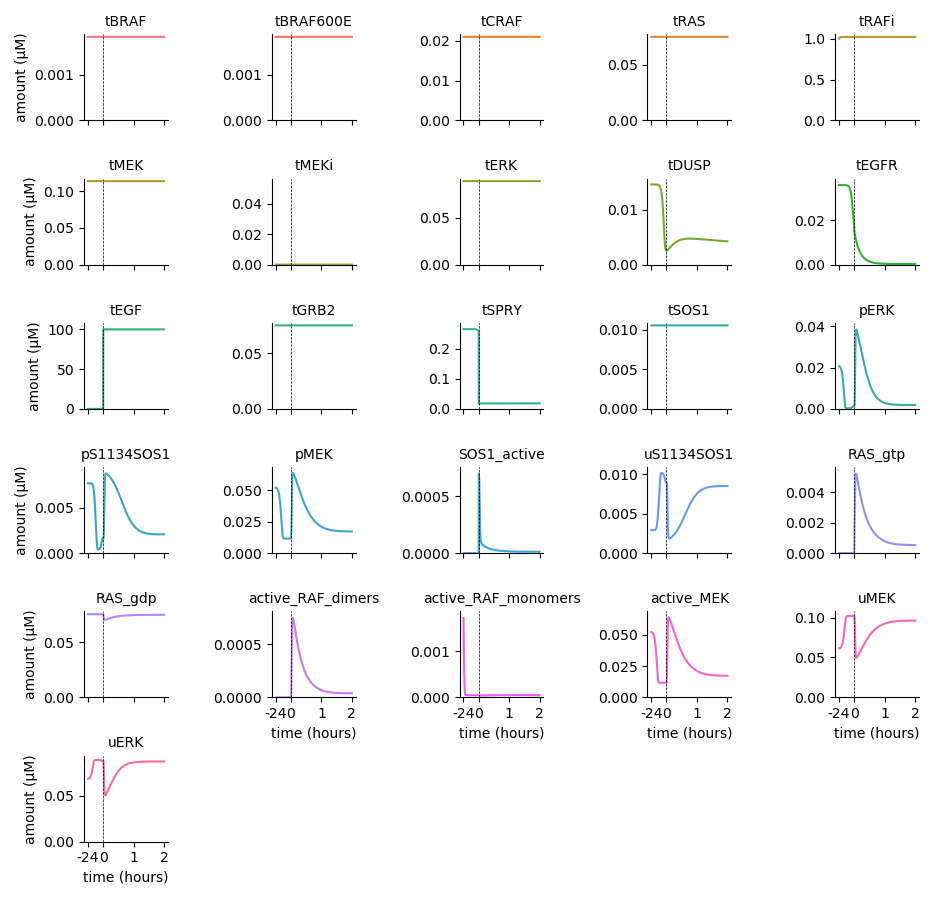

In [19]:
obs_melted = obs.reset_index().melt(id_vars='time')
g = sns.FacetGrid(
    obs_melted, col='variable', hue='variable', col_wrap=5, sharey=False,
    size=1.5, aspect=1.25
)
g.map(plt.plot, 'time', 'value')
for ax in g.axes:
    _, ymax = ax.get_ylim()
    ax.set_ylim(ymin=0, ymax=ymax * 1.03)
    ax.set_xticks([-0.5, 0, 1, 2])
    ax.set_xticklabels(['-24', '0', '1', '2'])
    ax.axvline(0, color='k', linewidth=0.5, linestyle='--')
g.set_titles('{col_name}')
g.set_xlabels('time (hours)')
g.set_ylabels('amount (\u03bcM)')
plt.tight_layout()